In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._20220615_00 import UserModel
from models.user_simulator import UserSimulator
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
tb_unit1 = pd.read_csv(
    os.path.join("tables", "tb_unit1.csv")
)
tb_unit2 = pd.read_csv(
    os.path.join("tables", "tb_unit2.csv")
)

c22c1 = {}
for _, row in tb_unit2.iterrows():
    c2 = row["name"]
    c1 = tb_unit1[tb_unit1["unit1Seq"] == row["unit1Seq"]]["name"].values[0]
    
    c22c1[c2] = c1

c22c1_indices = [dataset.c12idx[c22c1[c2]] for c2 in [dataset.c2_list[i] for i in range(dataset.num_c2)]]

In [4]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220615_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=80, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=2, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [5]:
simulator = UserSimulator(model)

In [6]:
test_dataset[20]

(array([3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 array([168, 168, 166, 167, 168, 168, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 180, 180, 179, 179, 180, 180]),
 array([2, 3, 4, 4, 4, 4, 2, 2, 4, 2, 3, 3, 4, 2, 3, 2, 3, 4, 3, 3, 3, 2,
        4,

In [7]:
# 0, 1, 3, 5, 19, 20
c1_seq, c2_seq, d_seq, r_seq = test_dataset[0]

c1_seq, c1shft_seq = [c1_seq[:-1]], [c1_seq[1:]]

c2_seq, c2shft_seq = [c2_seq[:-1]], [c2_seq[1:]]

d_seq, dshft_seq = [d_seq[:-1]], [d_seq[1:]]

r_seq, rshft_seq = [r_seq[:-1]], [r_seq[1:]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

c1_seq = np.array([[0] * seq_len])
c2_seq = np.array([[0] * seq_len])
d_seq = np.array([[6] * seq_len])

In [8]:
alpha_seq, r_seq, h_seq, C1_seq, C2_seq = simulator.simulate(
    LongTensor(c1_seq),
    LongTensor(c2_seq),
    LongTensor(d_seq),
)

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

CQ_seq = alpha_seq.unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()[0]

r_seq = r_seq.detach().cpu().numpy()

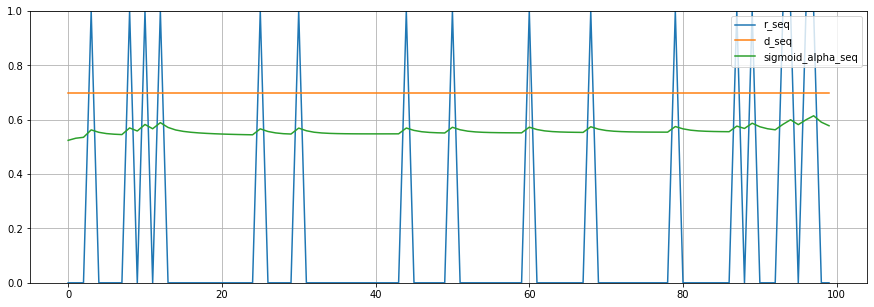

In [9]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

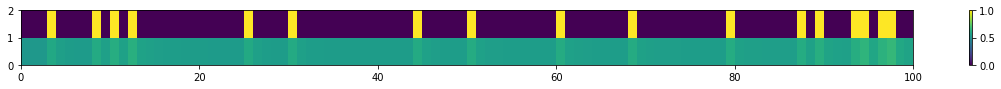

In [10]:
plt.figure(figsize=[20, (len(np.unique(c2_seq)) + 1) // 2], facecolor="white")
temp = np.concatenate([CQ_seq[:, np.unique(c2_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [13]:
alpha_seq, d_seq, r_seq, h_seq, C1_seq, C2_seq = simulator.expectimax(
    LongTensor(c1_seq),
    LongTensor(c2_seq),
)

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

CQ_seq = alpha_seq.unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()[0]

d_seq = d_seq.detach().cpu().numpy()
r_seq = r_seq.detach().cpu().numpy()

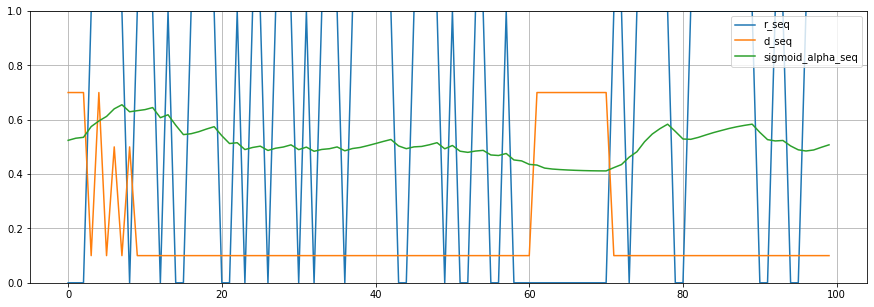

In [14]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()